# ESG分组的波动溢出网络

<div class="alert alert-info">
使用分位数来进行ESG分组，然后构建每组的ESG指数，再进行波动率溢出效应的度量，构建波动溢出网络。
    
Draft: 2024.9.1 Updated:2024.9.4 Version: 0.0.3
</div>


In [1]:
import pandas as pd
import numpy as np
df_prices = pd.read_csv('datasets/processed_data/close.csv')
df_prices.index = pd.to_datetime(df_prices['time'])
df_prices = df_prices.iloc[:, 1:]
df_prices.head(1)

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,601933,601939,601958,601988,601989,601991,601992,601996,601998,601999
time,,,,,,,,,,,,,,,,,,,,,
2010-01-04,926.73,1091.9,NaN,61.24,158.64,55.68,NaN,47.34,39.24,35.42,...,NaN,6.42,23.12,4.56,7.63,18.49,NaN,NaN,8.26,11.42


In [7]:
import pandas as pd
path='datasets/华证2009-2023年（含细分项+季度)）/华证esg评级2009-2023（细分项）/华证esg评级含细分项（季度）2009-2023.xlsx'
df_esg = pd.read_excel(path, dtype={'证券代码':str})
df_esg.head(1)

,证券代码,年份,证券简称,评级日期,综合评级,综合得分,E评级,E得分,S评级,S得分,G评级,G得分,证监会行业新,同花顺行业新,申万行业
0,1,2009,平安银行,1/31/2009,BBB,82.56,B,72.98,BBB,80.26,A,88.73,货币金融服务,股份制银行,股份制银行Ⅲ


In [8]:
df_esg['证券代码'] = df_esg['证券代码'].str.zfill(6)
df_esg['评级日期'] = pd.to_datetime(df_esg['评级日期'])
df_esg.index = df_esg['评级日期']

In [9]:
year = df_esg.index.year.astype(str)

In [10]:
month = df_esg.index.month.astype(str)

In [11]:
from tqdm.notebook import tqdm
df_esg['月份'] = ['%s-%s' %(year[i], month[i]) for i in tqdm(range(df_esg.shape[0]))]
df_esg.head(1)

  0%|          | 0/182660 [00:00<?, ?it/s]

,证券代码,年份,证券简称,评级日期,综合评级,综合得分,E评级,E得分,S评级,S得分,G评级,G得分,证监会行业新,同花顺行业新,申万行业,月份
评级日期,,,,,,,,,,,,,,,,
2009-01-31,000001,2009,平安银行,2009-01-31,BBB,82.56,B,72.98,BBB,80.26,A,88.73,货币金融服务,股份制银行,股份制银行Ⅲ,2009-1


In [14]:
df_esg.index = df_esg['月份'].values

In [15]:
esg_quantiles = df_esg.groupby('月份')['综合得分'].quantile([0.2, 0.4, 0.6, 0.8]).unstack()
esg_quantiles.head(5)

,0.2,0.4,0.6,0.8
月份,,,,
2009-1,68.53,70.72,72.580,74.950
2009-10,69.67,72.09,73.964,76.302
2009-4,69.05,71.39,73.470,75.910
2009-7,69.10,71.58,73.640,76.070
2010-1,69.56,72.09,74.112,76.398


In [34]:
resample_prices = df_prices.reindex(pd.date_range(start=df_prices.index.min(),
                                         end=df_prices.index.max(),
                                         freq='D'))

In [44]:
diff = np.log(resample_prices.resample('M').last() / resample_prices.resample('M').first())
diff.index = ['%s-%s' %(diff.index.year[i], diff.index.month[i]) for i in range(diff.shape[0])]
diff.head()

,000001,000002,000004,000005,000006,000007,000008,000009,000010,000011,...,601933,601939,601958,601988,601989,601991,601992,601996,601998,601999
2010-1,-0.088581,-0.126556,NaN,-0.105651,-0.110177,-0.002878,-0.191962,-0.038545,-0.033427,-0.089427,...,NaN,-0.079394,-0.106226,-0.047147,-0.010540,-0.058464,NaN,NaN,-0.152739,0.126501
2010-2,0.055400,0.002123,0.086611,0.029116,0.009704,0.102819,0.115265,0.078087,0.060851,0.057866,...,NaN,0.008496,0.058250,0.027652,-0.013851,0.022538,NaN,NaN,0.037254,0.134126
2010-3,0.003889,0.006346,0.045015,0.037627,0.141561,-0.035148,0.143101,0.042091,0.103037,0.136750,...,NaN,-0.005029,-0.045452,0.028923,-0.026857,-0.021138,NaN,NaN,0.032435,0.061495
2010-4,-0.129384,-0.221093,-0.097382,-0.236733,-0.252157,0.058932,-0.069029,-0.088765,0.032824,-0.392562,...,NaN,-0.083527,-0.054690,-0.028795,-0.044903,-0.074554,NaN,NaN,-0.199644,-0.170640
2010-5,-0.132954,-0.023254,-0.092307,-0.053725,-0.060356,-0.105095,0.108050,-0.133851,NaN,-0.078384,...,NaN,-0.050620,-0.149676,-0.011455,0.089196,-0.056748,NaN,NaN,-0.116947,-0.097239


In [45]:
# 为每个股票计算五分位
def assign_quantile(row):
    for quantile in [0.2, 0.4, 0.6, 0.8]:
        if row['综合得分'] <= esg_quantiles.loc[row['月份'], quantile]:
            return int(quantile * 5)
    return 5

df_esg['quantile'] = df_esg.apply(assign_quantile, axis=1)

In [46]:
pivot_df = pd.DataFrame()
for i in tqdm(range(diff.shape[1])):
    df = pd.DataFrame()
    df['收益率'] = diff.iloc[:, i]
    df['证券代码'] = diff.columns[i]
    pivot_df = pd.concat([pivot_df, df])

  0%|          | 0/2212 [00:00<?, ?it/s]

In [47]:
pivot_df

,收益率,证券代码
2010-1,-0.088581,000001
2010-2,0.055400,000001
2010-3,0.003889,000001
2010-4,-0.129384,000001
2010-5,-0.132954,000001
...,...,...
2024-2,-0.026126,601999
2024-3,0.035289,601999
2024-4,-0.104026,601999
2024-5,-0.083827,601999


In [48]:
ret = []
for i in tqdm(range(df_esg.shape[0])):
    if df_esg.iloc[i]['月份'] in diff.index and df_esg.iloc[i]['证券代码'] in diff.columns: 
        ret.append(diff.loc[df_esg.iloc[i]['月份'], df_esg.iloc[i]['证券代码']])
    else:
        ret.append(np.nan)

  0%|          | 0/182660 [00:00<?, ?it/s]

In [49]:
df_esg['收益率'] = ret

In [50]:
df_esg.head()

,证券代码,年份,证券简称,评级日期,综合评级,综合得分,E评级,E得分,S评级,S得分,G评级,G得分,证监会行业新,同花顺行业新,申万行业,月份,quantile,收益率
2009-1,000001,2009,平安银行,2009-01-31,BBB,82.56,B,72.98,BBB,80.26,A,88.73,货币金融服务,股份制银行,股份制银行Ⅲ,2009-1,5,NaN
2009-4,000001,2009,平安银行,2009-04-30,BBB,82.26,CCC,69.87,BB,77.46,AA,91.51,货币金融服务,股份制银行,股份制银行Ⅲ,2009-4,5,NaN
2009-7,000001,2009,平安银行,2009-07-31,BBB,82.81,CCC,69.87,BB,77.46,AA,92.70,货币金融服务,股份制银行,股份制银行Ⅲ,2009-7,5,NaN
2009-10,000001,2009,平安银行,2009-10-31,BBB,82.38,CCC,69.87,BB,77.46,AA,91.77,货币金融服务,股份制银行,股份制银行Ⅲ,2009-10,5,NaN
2010-1,000001,2010,平安银行,2010-01-31,BBB,82.81,CCC,69.87,BB,77.46,AA,92.70,货币金融服务,股份制银行,股份制银行Ⅲ,2010-1,5,-0.088581


In [51]:
a = df_esg.groupby(['quantile', '月份'])['收益率'].mean()

/Users/hans/opt/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  func(*args, **kwargs)
/Users/hans/opt/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from current font.
  func(*args, **kwargs)
/Users/hans/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hans/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20221 (\N{CJK UNIFIED IDEOGRAPH-4EFD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


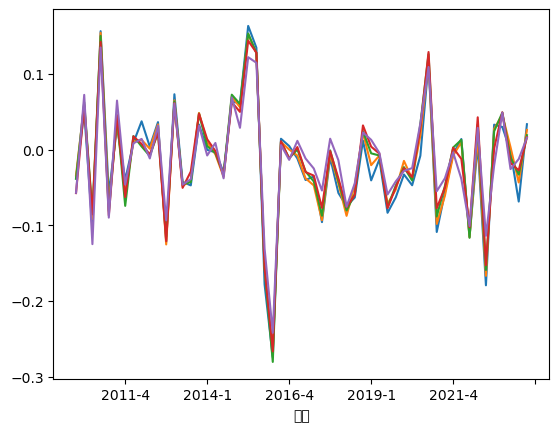

In [52]:
import matplotlib.pyplot as plt
for i in [1,2,3,4,5]:
    a[i].index = pd.to_datetime(a[i].index)
    b = a[i].sort_index()
    b.plot()

In [53]:
from arch import arch_model
from joblib import Parallel, delayed
from tqdm import tqdm

def estimate_volatility_single_series(returns):
    model = arch_model(returns, vol='Garch', p=1, q=1)
    res = model.fit(disp='off')
    return res.conditional_volatility

In [54]:
def estimate_volatility(returns, n_jobs=50):
    # 使用并行处理每列数据
    results = Parallel(n_jobs=n_jobs)(delayed(estimate_volatility_single_series)(returns[col]) for col in tqdm(returns.columns))
    
    # 将结果合并为一个 DataFrame
    volatilities = pd.concat(results, axis=1)
    volatilities.columns = returns.columns
    volatilities.index = returns.index
    
    return volatilities

In [60]:
a[1].pd.to_datetime(a[1].index)

DatetimeIndex(['2009-01-01', '2009-10-01', '2009-04-01', '2009-07-01',
               '2010-01-01', '2010-10-01', '2010-04-01', '2010-07-01',
               '2011-01-01', '2011-10-01', '2011-04-01', '2011-07-01',
               '2012-01-01', '2012-10-01', '2012-04-01', '2012-07-01',
               '2013-01-01', '2013-10-01', '2013-04-01', '2013-07-01',
               '2014-01-01', '2014-10-01', '2014-04-01', '2014-07-01',
               '2015-01-01', '2015-10-01', '2015-04-01', '2015-07-01',
               '2016-01-01', '2016-10-01', '2016-04-01', '2016-07-01',
               '2017-01-01', '2017-10-01', '2017-04-01', '2017-07-01',
               '2018-01-01', '2018-10-01', '2018-04-01', '2018-07-01',
               '2019-01-01', '2019-10-01', '2019-04-01', '2019-07-01',
               '2020-01-01', '2020-10-01', '2020-04-01', '2020-07-01',
               '2021-01-01', '2021-10-01', '2021-04-01', '2021-07-01',
               '2022-01-01', '2022-10-01', '2022-04-01', '2022-07-01',
      

In [55]:
volatilities = estimate_volatility(a[1]*100.)

AttributeError: 'Series' object has no attribute 'columns'

## 分位数

In [ ]:
quantile_close_df = pd.DataFrame()
for i in range(5):
    score = ESG_df['综合得分'].quantile(0.20*(i+1))
    score2 = ESG_df['综合得分'].quantile(0.2*i)
    cond = (ESG_df['综合得分']>=score2) * (ESG_df['综合得分']<=score)
    num = ESG_df.loc[cond].shape[0]
    print('分位数:', i+1, '数值:', score, '个数:', num)
    quantile_close_df = close_df[ESG_df.loc[cond]['股票代码']].mean()
    break

In [ ]:
quantile_close_df

## 合成5个ESG指数

In [ ]:
import numpy as np
vol_interday = calculate_volatility(open_df, high_df, low_df, close_df)
vol_interday = vol_interday.ffill()
# 控制缺失值的数量
vol_interday = vol_interday.loc[:, (vol_interday.isnull().sum()>500) == False].dropna()
vol_interday.shape

### 数据平稳性检验和差分处理

In [ ]:
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
adf_no_list = []
def check_stationarity(series):
    result = adfuller(series)
    return result[1]  # 返回p值


for col in tqdm(volatilities.columns):
    p_value = check_stationarity(volatilities[col])
    if p_value > 0.05:            # 如果p值大于0.05，进行差分
        adf_no_list.append(col)
print(len(adf_no_list))

In [ ]:
print(len(adf_no_list))

### 波动率溢出指数

使用Diebold和Yilmaz的方法计算波动率溢出指数。该方法通过VAR（向量自回归）模型计算不同时间序列之间的波动率传递和溢出效应。


In [ ]:
volatilities = volatilities.drop(adf_no_list, axis=1)
volatilities.shape

In [ ]:
# 查找全是常数的列
constant_columns = [col for col in volatilities.columns if volatilities[col].nunique() < 100]
constant_columns

In [ ]:
# 删除全是常数的列
volatilities = volatilities.drop(columns=constant_columns)

In [ ]:
volatilities = volatilities.iloc[:252, :300]
volatilities.to_csv('datasets/processed_data/volatilities.csv')

In [ ]:
from statsmodels.tsa.api import VAR
model = VAR(volatilities)
results = model.fit(maxlags=5)
H=5

In [ ]:
from tqdm import tqdm
# 获取模型残差的协方差矩阵及其逆矩阵
sigma_u = results.sigma_u
sigma_u_inv = np.linalg.inv(sigma_u)

# 计算 GFEVD
def compute_gfevd(H, A, sigma_u, sigma_u_inv):
    n_vars = A.shape[1]
    gfevd = np.zeros((n_vars, n_vars))
    e = np.eye(n_vars)
    
    for i in tqdm(range(n_vars)):
        for j in range(n_vars):
            num = sigma_u_inv[j, j] * np.sum([(e[i].T @ A[h] @ sigma_u @ e[j]) ** 2 for h in range(H)]) 
            den = np.sum([(e[i].T @ A[h] @ sigma_u @ A[h].T @ e[i]) for h in range(H)])
            gfevd[i, j] = num / den
    return gfevd


In [ ]:
MA_A = results.ma_rep(maxn=5)

In [ ]:
# 计算 GFEVD
gfevd = compute_gfevd(H, MA_A, sigma_u, sigma_u_inv)

gfevd = pd.DataFrame(gfevd[:,:], index=volatilities.columns,
             columns=volatilities.columns)

gfevd

In [ ]:
a = gfevd/10e14
plt.hist(a.values.ravel())

### 归一化

In [ ]:
def scale_one(df):
    # j 归一化
    s1 = df.values
    s2 = df.values.sum(axis=1)
    s3 = (s1.T/s2).T
    return pd.DataFrame(s3, index=df.index, columns=df.index)

In [ ]:
spillover_matrix = scale_one(gfevd)
spillover_matrix

In [ ]:
import pandas as pd
path='datasets/华证2009-2023年（含细分项+季度)）/华证esg评级2009-2023（细分项）/华证esg评级含细分项（年度）2009-2023.xlsx'
ESG_df = pd.read_excel(path, dtype={'股票代码':str})
ESG_df['股票代码'] = ESG_df['股票代码'].str.zfill(6)
ESG_df.head(1)

In [ ]:
ESG = ESG_df[['股票代码', '综合得分']].groupby('股票代码').mean()

In [ ]:
df = pd.DataFrame((gfevd/10e14).sum(axis=0), columns=['spillover'])
df['ESG_Score'] = ESG
df

In [ ]:
df.plot(kind='scatter', x='ESG_Score', y='spillover')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

In [ ]:
# 计算皮尔逊相关系数
corr, p_value = pearsonr(df['spillover'], df['ESG_Score'])
print(f"Pearson correlation coefficient: {corr:.4f}, P-value: {p_value:.4f}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm

X = df['spillover']
y = df['ESG_Score']
X = sm.add_constant(X)  # 添加常数项
model = sm.OLS(y, X).fit()
print(model.summary())

### 净溢出

检查是否需要标准化

In [ ]:
spillover_matrix.sum().sum() 

In [ ]:
net_spillover_matrix = spillover_matrix.copy() * 0.
for i in spillover_matrix.index:
    for j in spillover_matrix.columns:
        net = spillover_matrix.loc[i,j] - spillover_matrix.loc[j,i]
        if net >= 0:
            net_spillover_matrix.loc[i,j] = net
        else:
            net_spillover_matrix.loc[j,i] = -1 * net

### 热力图

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 

sns.heatmap(net_spillover_matrix, annot=True, fmt=".3f", cmap="YlGnBu")

plt.title("Net Spillover Matrices")

plt.show()


In [ ]:
import pandas as pd
net_spillover_matrix = pd.read_csv('bb.csv', index_col=0, dtype={'code':str})
net_spillover_matrix = net_spillover_matrix.iloc[:100, :100]

## 构建溢出网络

根据计算得到的溢出指数，构建各个股票网络之间的溢出矩阵。


将溢出矩阵转换为图网络，节点代表股票，边的权重代表波动率溢出的强度。


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def build_spillover_network(spillover_matrix):
    G = nx.DiGraph()
    num_nodes = spillover_matrix.shape[0]
    for i in tqdm(spillover_matrix.index):
        for j in spillover_matrix.columns:
            if i != j:
                G.add_edge(i, j, weight=spillover_matrix.loc[i, j])
    return G

G = build_spillover_network(net_spillover_matrix)


In [ ]:
import seaborn as sns
# 使用Seaborn的调色板生成九种颜色
palette = sns.color_palette("husl", 9)
# 转换为十六进制颜色代码
colors_list = [sns.desaturate(color, 0.8) for color in palette]

In [ ]:
# import matplotlib.patches as mpatches
# ESG_rate = np.array(['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C'])
# node_colors = []
# used_rate = set()
# for code in net_spillover_matrix.index:
#     a = ESG_df.loc[ESG_df['证券代码'] == str(code), 'ESG评级'].values[0]
#     loc = np.where(ESG_rate == str(a))[0][0]
#     node_colors.append(colors_list[loc])
#     used_rate.add(loc)
# legend_color = []
# for c in used_rate:
#     legend_color.append(mpatches.Patch(color=colors_list[c], label=ESG_rate[c]))

In [ ]:
import numpy as np
# 定义边的权重
edge_weights = []
for u, v in G.edges():
    if G[u][v]['weight'] == 0:
        edge_weights.append(np.nan)
    else:
        if np.abs(G[u][v]['weight']*20 )/10>10:
            edge_weights.append(np.abs(G[u][v]['weight']*20 )/10)
        else:
            edge_weights.append(np.nan)

In [ ]:
(~np.isnan(edge_weights)).sum()

In [ ]:
import matplotlib.cm as cm
plt.figure(figsize=(6, 6))  
pos = nx.spring_layout(G)  # 使用弹簧布局

#node_style = { 'node_size': 100, 'alpha': 0.8} #'node_color': node_colors,
edge_style = {'width': edge_weights, 'alpha': 0.5} #'edge_color': 'gray', 
nx.draw(G,
        pos=pos,
        with_labels=False, 
        font_size=6,
        font_color='black',
        font_weight='bold',
        arrows=True,
        arrowsize=8,
        #**node_style,
        **edge_style
       )

#plt.legend(handles=legend_color, loc='best')

In [ ]:
sns.clustermap(net_spillover_matrix)